In [11]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [12]:
import os
import pickle
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit
import pymc3 as pm
import arviz as az

In [13]:
import warnings
warnings.simplefilter('ignore')

In [14]:
# multiprocessing.set_start_method("fork")
sns.set()  # Nice plot aesthetic

In [15]:
bkp_folder = 'bkp'
os.makedirs(bkp_folder, exist_ok=True)

# Toy example

In [16]:
def true_f(x):
    return x**0.7

x = np.random.random(size=10)
y = true_f(x)

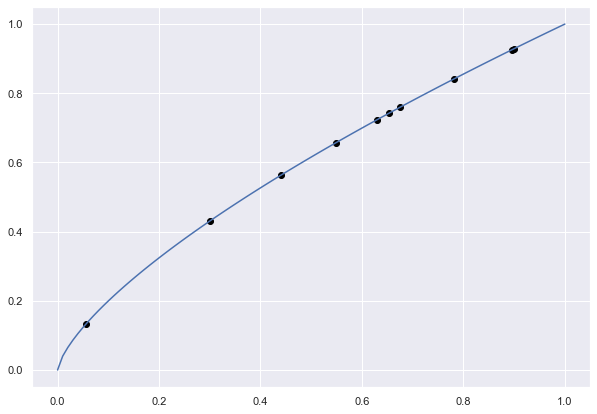

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(x, y, c="black")

x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, true_f(x_plot))

In [18]:
with pm.Model() as toy_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=0)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    gp.marginal_likelihood('y', X=x.reshape(-1, 1), y=y, noise=σ)
    

INFO:filelock:Lock 4963071120 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4963071120 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4963377504 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4963377504 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4962834320 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4962834320 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4963874176 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4963874176 released on /Users/aureliennioche/.theano/comp

In [19]:
with toy_model:
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

INFO:filelock:Lock 4959828672 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4959828672 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4959853776 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4959853776 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4959477664 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4959477664 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4958643296 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4958643296 released on /Users/aureliennioche/.theano/comp

INFO:pymc3:Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 25 seconds.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [20]:
# with gp_salmon_model:
#     fit = pm.find_MAP()
# fit

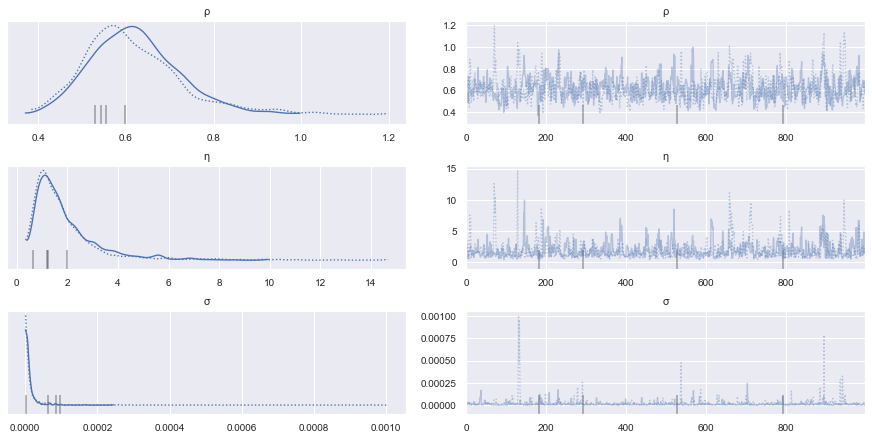

In [21]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [22]:
x_pred = np.linspace(0, 1, 100)
with toy_model:
    y_pred = gp.conditional("y_pred", x_pred.reshape(-1, 1))
    samples = pm.sample_posterior_predictive(gp_trace, var_names=["y_pred"], samples=3, random_seed=42)

INFO:filelock:Lock 4971256320 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4971256320 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4971140528 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4971140528 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4964618832 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4964618832 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4958405488 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4958405488 released on /Users/aureliennioche/.theano/comp

INFO:filelock:Lock 4959159200 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4959159200 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4959160160 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4959160160 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4958824432 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4958824432 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4959162128 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4959162128 released on /Users/aureliennioche/.theano/comp

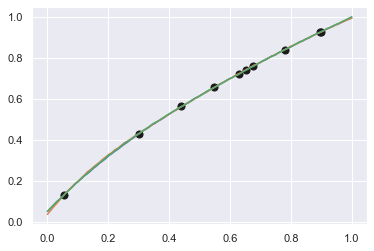

In [23]:
fig, ax = plt.subplots()
ax.scatter(x=x, y=y, c='k', s=50)
# ax.set_ylim(0, None)
for y_ in samples['y_pred']:
    ax.plot(x_pred, y_);

In [24]:
with toy_model:
    more_samples = pm.sample_posterior_predictive(gp_trace, var_names=["y_pred"], samples=100, random_seed=42)

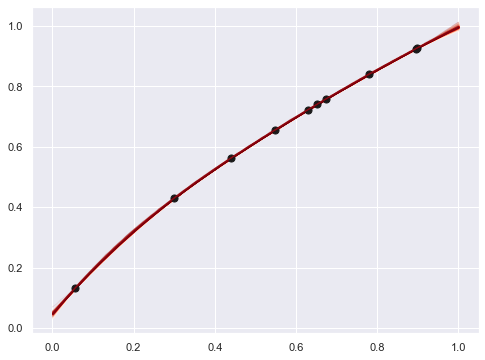

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
pm.gp.util.plot_gp_dist(ax, more_samples['y_pred'], x_pred)
ax.scatter(x=x, y=y, c='k', s=50)

In [26]:
# with gp_salmon_model:
#     salmon_pred_noise = recruit_gp.conditional("salmon_pred_noise", X_pred.reshape(-1,1), pred_noise=True)
#     gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=["salmon_pred_noise"], samples=500, random_seed=42)

# Toy model 2

In [27]:
def true_f(x):
    return np.sign(x)*np.abs(x)**0.7

x = np.random.uniform(-2, 2, size=100)
x.sort()
u = true_f(x)
p_logit = 1/(1+np.exp(-3.33*u))
y = p_logit > np.random.random(len(x))

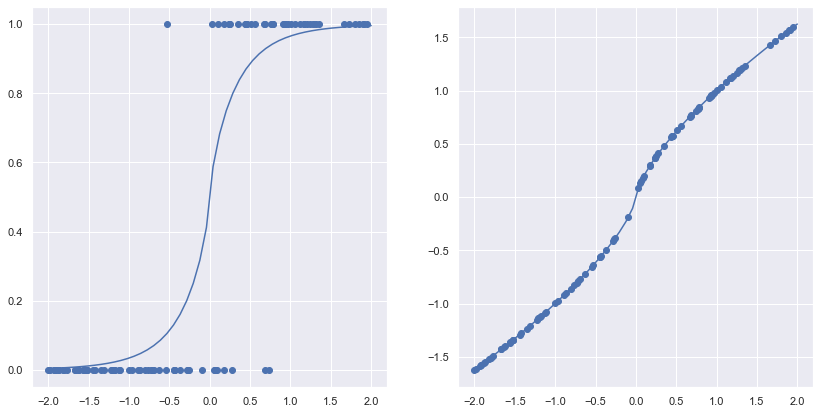

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 7))
ax = axes[0]
ax.scatter(x, y)
x_plot = np.linspace(-2, 2, )
ax.plot(x_plot, 1/(1+np.exp(-3.33*true_f(x_plot))))

ax = axes[1]
ax.scatter(x, u)
ax.plot(x_plot, true_f(x_plot))

In [29]:
with pm.Model() as toy_model:
    
    ρ = pm.Normal('ρ', 1)
    η = pm.Normal('η', 1)
    
    K = η**2 * pm.gp.cov.ExpQuad(1, ρ)
    gp = pm.gp.Latent(cov_func=K)
    
    f = gp.prior('f', X=x.reshape(-1, 1))
    p = pm.Deterministic('p', pm.math.invlogit(3.33*f))
    y_ = pm.Bernoulli('y', p=p, observed=y)

INFO:filelock:Lock 4962502880 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4962502880 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4970192512 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4970192512 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4972461696 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4972461696 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4972417088 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4972417088 released on /Users/aureliennioche/.theano/comp

INFO:filelock:Lock 4966294000 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4966091936 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4966091936 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4966405600 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4966405600 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4966465104 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4966465104 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4966378800 acquired on /Users/aureliennioche/.theano/comp

In [30]:
with toy_model:
    trace = pm.sample(1000, tune=1000, chains=2)

INFO:filelock:Lock 4966295536 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4966295536 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4968289088 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4968289088 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4968052672 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4968052672 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4968226048 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4968226048 released on /Users/aureliennioche/.theano/comp

INFO:filelock:Lock 4978537280 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4978537280 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4978857632 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4978857632 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4978984944 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4978984944 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4978986672 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4978986672 released on /Users/aureliennioche/.theano/comp

INFO:filelock:Lock 4985559072 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4986059504 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4986059504 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4985755296 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4985755296 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4955737920 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4955737920 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 4973472736 acquired on /Users/aureliennioche/.theano/comp

INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 94 seconds.
ERROR:pymc3:There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


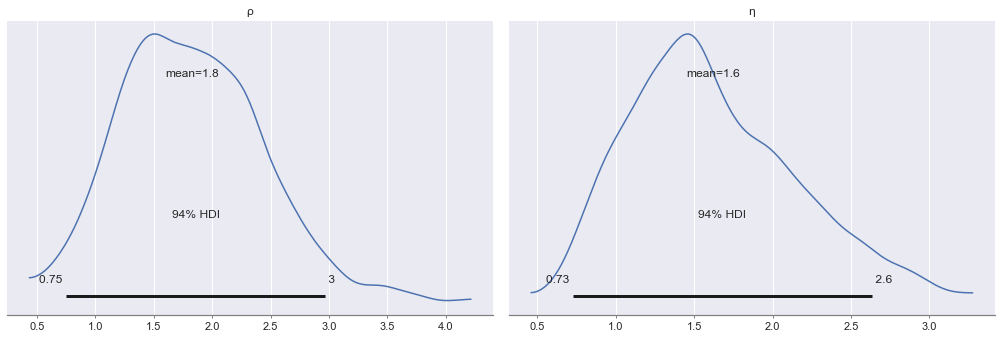

In [31]:
az.plot_posterior(trace, var_names=['ρ', 'η']);

In [32]:
with toy_model:
    y_pred = pm.sample_posterior_predictive(trace, var_names=["f", "p"], samples=1000)

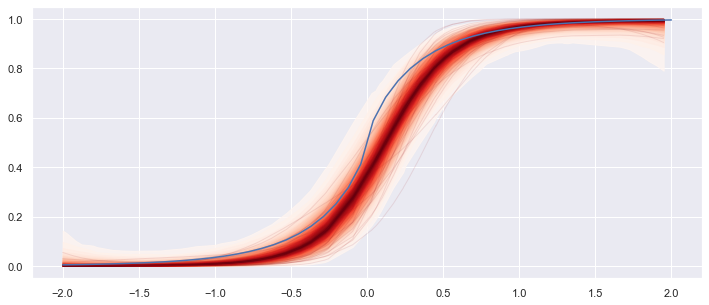

In [33]:
# link function
def invlogit(x, eps=np.finfo(np.double).resolution):
    return (1.0 + 2.0 * eps) / (1.0 + np.exp(-x)) + eps

fig, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, invlogit(3.33*y_pred["f"]), x)
ax.plot(x_plot, 1/(1+np.exp(-3.33*np.sign(x_plot)*np.abs(x_plot)**0.7)))

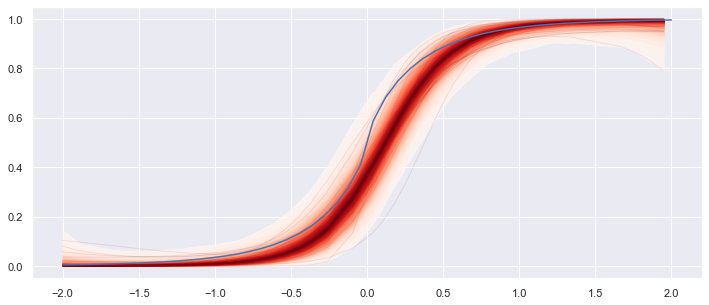

In [34]:
fig, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, y_pred["p"], x)
ax.plot(x_plot, 1/(1+np.exp(-3.33*np.sign(x_plot)*np.abs(x_plot)**0.7)))

(-2.0, 2.0)

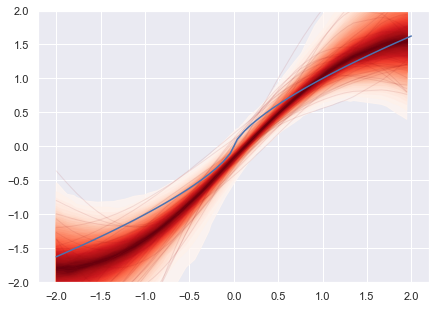

In [35]:
fig, ax = plt.subplots(figsize=(7,5))

pm.gp.util.plot_gp_dist(ax, y_pred["f"], x)
ax.plot(x_plot, np.sign(x_plot)*np.abs(x_plot)**0.7)

ax.set_ylim(-2, 2)

## Lottery data

In [130]:
np.random.seed(123)

In [131]:
def u(x, alpha):
    return x**(1 - alpha)

In [132]:
# steps = np.linspace(0.01,0.99, 10)
# task = pd.DataFrame(np.array(list(it.product(steps, repeat=4))), columns=["p0", "x0", "p1", "x1"])
task = pd.DataFrame(np.random.random(size=(1000, 4)), columns=["p0", "x0", "p1", "x1"])
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]

In [133]:
n_trial = len(task)

tau = 0.1
true_alpha = 0.4

seu0 = task.p0 * u(task.x0, true_alpha)
seu1 = task.p1 * u(task.x1, true_alpha)

p_choice_1 = scipy.stats.norm.cdf(seu1 - seu0) # expit((seu1 - seu0)/tau)

choice = np.zeros(n_trial, dtype=int)
choice[:] = p_choice_1 > np.random.random(size=n_trial)
task["choice"] = choice

n = 100
task = task.sample(n=n, replace=False)
task.reset_index(inplace=True, drop=True)
task

,p0,x0,p1,x1,choice
0,0.826036,0.021390,0.283302,0.535306,0
1,0.968482,0.358210,0.698716,0.462476,0
2,0.171865,0.820053,0.319198,0.125665,1
3,0.356261,0.255813,0.251399,0.317453,1
4,0.068537,0.207511,0.100055,0.003384,0
...,...,...,...,...,...
95,0.866309,0.250455,0.483034,0.985560,1
96,0.584525,0.066603,0.221298,0.948440,1
97,0.556785,0.158960,0.153071,0.695530,1
98,0.130992,0.891755,0.250271,0.605698,0


In [139]:
p0 = task.p0.values
p1 = task.p1.values
x0 = task.x0.values
x1 = task.x1.values
y = task.choice.values

x = np.hstack((x0, x1))
X = x.reshape((2, n)).T
# print(X)

x_order = np.argsort(x)
x_sorted = x[x_order]
undo_sorted = np.argsort(x_order)

In [146]:
lin_func = pm.gp.mean.Linear(coeffs=(1,), intercept=(0,))

X = np.linspace(0, 1, 10).reshape((-1, 1))
print(lin_func(X).eval())

INFO:filelock:Lock 5036060384 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 5036060384 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 5036171520 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 5036171520 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 5036209152 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 5036209152 released on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 5036210016 acquired on /Users/aureliennioche/.theano/compiledir_macOS-11.2-x86_64-i386-64bit-i386-3.9.1-64/.lock
INFO:filelock:Lock 5036210016 released on /Users/aureliennioche/.theano/comp

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


In [167]:
with pm.Model() as toy_model:
    
    ℓ = pm.Normal('ℓ', 1)
    η = pm.Normal('η', 1)
    
#     # informative lengthscale prior
#     ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
#     # informative, positive normal prior on the period
#     η = pm.HalfNormal("η", sigma=5)
    
    K = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Latent(mean_func=pm.gp.mean.Linear(coeffs=(1,), intercept=(0,)), cov_func=K)
    
    f = gp.prior('f', X=x_sorted.reshape((-1, 1)))
    u_ = pm.math.exp(f[undo_sorted].reshape((2, n)))
    u0 = u_[0]
    u1 = u_[1]
    diffeu = p1*u1 - p0*u0
    
#     diffeu_order = np.argsort(diffeu)
#     sorted_diffeu = diffeu[diffeu_order]
#     print(type(diffeu_order))
    # sorted_y = y[diffeu_order]
    p_ = pm.Deterministic('p', pm.math.invlogit(3.33*diffeu))
    y_ = pm.Bernoulli('y', p=p_, observed=y)

In [168]:
with toy_model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:NUTS: [f_rotated_, η, ℓ]


INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 126 seconds.
ERROR:pymc3:There were 472 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


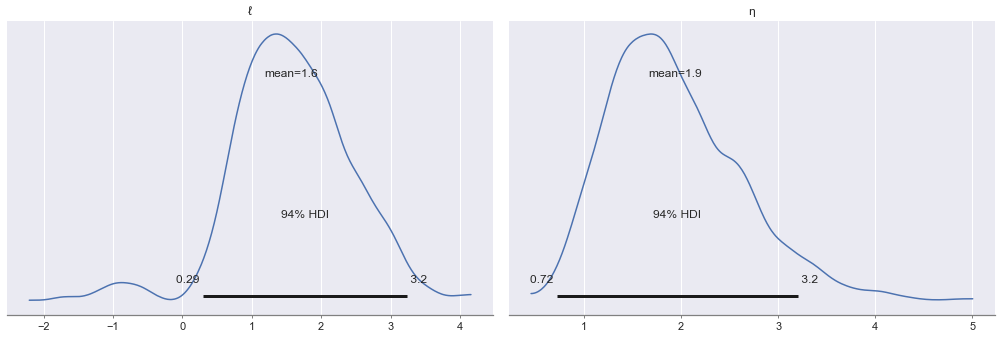

In [169]:
az.plot_posterior(trace, var_names=['ℓ', 'η']);

In [170]:
# x_plot = np.linspace(0, 1, 100)

# with toy_model:
    # y_star = gp.conditional("f_star", x_plot.reshape((-1, 1)))
    # y_pred = pm.sample_posterior_predictive(trace, var_names=["f_star"], samples=1000)

<AxesSubplot:>

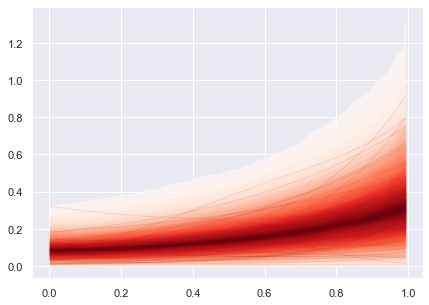

In [171]:
fig, ax = plt.subplots(figsize=(7,5))

# pm.gp.util.plot_gp_dist(ax, y_pred["p"], np.linspace(-1, 0, 1))
# ax.plot(x_plot, np.sign(x_plot)*np.abs(x_plot)**0.7)

pm.gp.util.plot_gp_dist(ax, np.exp(trace.posterior["f"][0, :, :]), x_sorted.reshape((-1, 1)))

In [166]:
# pm.gp.util.plot_gp_dist(ax, trace.posterior["p"][0, :, :], )

In [ ]:
# fig, ax = plt.subplots(figsize=(12,5))

# pm.gp.util.plot_gp_dist(ax, y_pred["f"], x_sorted)
# ax.plot(x_plot, 1/(1+np.exp(-3.33*np.sign(x_plot)*np.abs(x_plot)**0.7)))